In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import copy
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder


Data Labelling

In [2]:

os.makedirs("dataset_info", exist_ok=True) 

def create_csv(image_folder, output_csv):
    data = []
    for label_name in os.listdir(image_folder):
        label_folder = os.path.join(image_folder, label_name)
        if not os.path.isdir(label_folder):
            continue

        label = "bonafide" if label_name.lower() == "bonafide" else "attack"

        for img in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img)
            data.append([img_path.replace("\\", "/"), label])

    df = pd.DataFrame(data, columns=["image_path", "label"])
    df.to_csv(output_csv, index=False)
    print(f"CSV saved: {output_csv}, Total: {len(df)}")

create_csv("./SMDD_preprocessed/train", "dataset_info/train.csv")
create_csv("./SMDD_preprocessed/test", "dataset_info/test.csv")


CSV saved: dataset_info/train.csv, Total: 21360
CSV saved: dataset_info/test.csv, Total: 39710


Data Augmentation + Normalization + Resizing

In [3]:
from torchvision import transforms

INPUT_SIZE = 224
PRE_MEAN = [0.485, 0.456, 0.406]
PRE_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=PRE_MEAN, std=PRE_STD)
])

test_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=PRE_MEAN, std=PRE_STD)
])


Data Separation

In [4]:
root = "./SMDD_preprocessed/train"

full_dataset = ImageFolder(root=root)

# ===========================
# TRAIN/VAL SPLIT
# ===========================
val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# ===========================
# APPLY DIFFERENT TRANSFORMS
# ===========================

# Attach transforms individually
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform

# ===========================
# PRINT INFO
# ===========================
print("Total images:", len(full_dataset))
print("Training images:", len(train_subset))
print("Validation images:", len(val_subset))

Total images: 21360
Training images: 17088
Validation images: 4272


In [6]:
from torch.utils.data import DataLoader

# ===========================
# DATALOADERS
# ===========================

train_loader = DataLoader(
    train_subset, 
    batch_size=16, 
    shuffle=True,      # shuffle ONLY training
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset, 
    batch_size=16, 
    shuffle=False,     # NEVER shuffle validation
    num_workers=4,
    pin_memory=True
)

dataloaders = {
    "train": train_loader,
    "val": val_loader
}

dataset_sizes = {
    "train": len(train_subset),
    "val": len(val_subset)
}

print("Train loader size:", dataset_sizes["train"])
print("Val loader size:", dataset_sizes["val"])


Train loader size: 17088
Val loader size: 4272


In [7]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

# Load pretrained EfficientNet-B3
model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)

# Replace final classification layer for 2 classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    early_stop_patience = 5
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # 🔥 Step scheduler ONLY during validation
            if phase == 'val':
                scheduler.step(epoch_loss)

                # Early stopping check
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    epochs_no_improve = 0
                    best_model_wts = copy.deepcopy(model.state_dict())
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= early_stop_patience:
                    print("Early stopping triggered!")
                    model.load_state_dict(best_model_wts)
                    return model

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    model.load_state_dict(best_model_wts)
    return model


In [9]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
GPU name: NVIDIA GeForce RTX 2050


In [10]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=10)
torch.save(model_trained.state_dict(), "efficientnet_b3_morphing.pth")


Epoch 1/10
------------------------------
train Loss: 0.0416 Acc: 0.9865
val Loss: 0.0012 Acc: 0.9998
Epoch 2/10
------------------------------
train Loss: 0.0021 Acc: 0.9995
val Loss: 0.0001 Acc: 1.0000
Epoch 3/10
------------------------------
train Loss: 0.0037 Acc: 0.9989
val Loss: 0.0003 Acc: 1.0000
Epoch 4/10
------------------------------
train Loss: 0.0011 Acc: 0.9996
val Loss: 0.0001 Acc: 1.0000
Epoch 5/10
------------------------------
train Loss: 0.0029 Acc: 0.9987
val Loss: 0.0003 Acc: 0.9998
Epoch 6/10
------------------------------
train Loss: 0.0003 Acc: 0.9999
val Loss: 0.0002 Acc: 1.0000
Epoch 7/10
------------------------------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.0005 Acc: 0.9998
Early stopping triggered!


In [11]:
class MorphingClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(MorphingClassifier, self).__init__()
        self.backbone = models.efficientnet_b3(pretrained=False)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)
# Load checkpoint
state_dict = torch.load("efficientnet_b3_morphing.pth", map_location="cpu")

# If model was saved without 'backbone.' prefix, fix key names
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("features.") or k.startswith("classifier."):
        new_state_dict[f"backbone.{k}"] = v
    else:
        new_state_dict[k] = v

# Initialize model and load modified state_dict
model_trained = MorphingClassifier()
missing, unexpected = model_trained.load_state_dict(new_state_dict, strict=False)
print("✅ Model loaded successfully!")
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

C:\Users\kekyi\AppData\Local\Temp\ipykernel_27572\703710272.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("efficientnet_b3_morphing.pth", map_

✅ Model loaded successfully!
Missing keys: []
Unexpected keys: []


In [12]:
test_dataset = datasets.ImageFolder("./SMDD_preprocessed/test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Classes:", test_dataset.classes)
print("Number of test images:", len(test_dataset))


Classes: ['bonafide', 'morphed']
Number of test images: 39710


In [13]:
model_trained.eval()
model_trained.to(device)
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_trained(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")



Test Accuracy: 98.98%


In [14]:

class SharedEncoder(nn.Module):
    """Shared EfficientNet-B3 feature extractor used by both S-MAD and D-MAD."""
    def __init__(self):
        super(SharedEncoder, self).__init__()
        base_model = models.efficientnet_b3(pretrained=True)
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return x

# initialize the shared encoder
shared_encoder = SharedEncoder().to(device)

c:\Users\kekyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Load your trained S-MAD weights
state_dict = torch.load("efficientnet_b3_morphing.pth", map_location="cpu")

# Initialize the shared encoder
shared_encoder = SharedEncoder()

# If your S-MAD model used the same EfficientNet-B3 backbone,
# load the feature extractor weights only
encoder_dict = shared_encoder.state_dict()
pretrained_dict = {k: v for k, v in state_dict.items() if k in encoder_dict}
encoder_dict.update(pretrained_dict)
shared_encoder.load_state_dict(encoder_dict, strict=False)

print("✅ Shared encoder initialized with S-MAD pretrained weights.")


C:\Users\kekyi\AppData\Local\Temp\ipykernel_27572\2468961676.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("efficientnet_b3_morphing.pth", map_

✅ Shared encoder initialized with S-MAD pretrained weights.


In [16]:
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

C:\Users\kekyi\AppData\Local\Temp\ipykernel_27572\214600722.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



=== Model Evaluation Metrics ===
Accuracy : 0.9898
Precision: 0.9999
Recall   : 0.9729
F1-score : 0.9862
ROC-AUC  : 1.0000

Classification Report:

              precision    recall  f1-score   support

    bonafide       0.98      1.00      0.99     24715
     morphed       1.00      0.97      0.99     14995

    accuracy                           0.99     39710
   macro avg       0.99      0.99      0.99     39710
weighted avg       0.99      0.99      0.99     39710



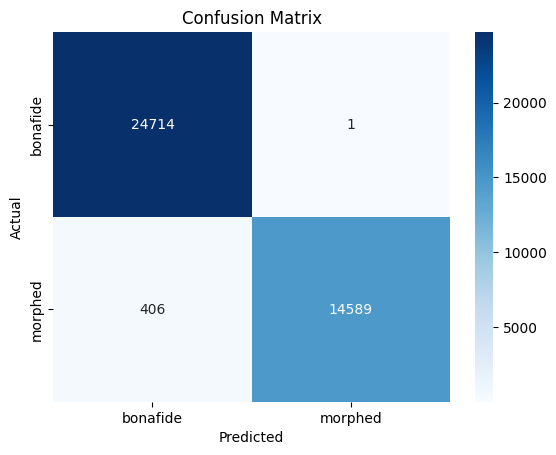

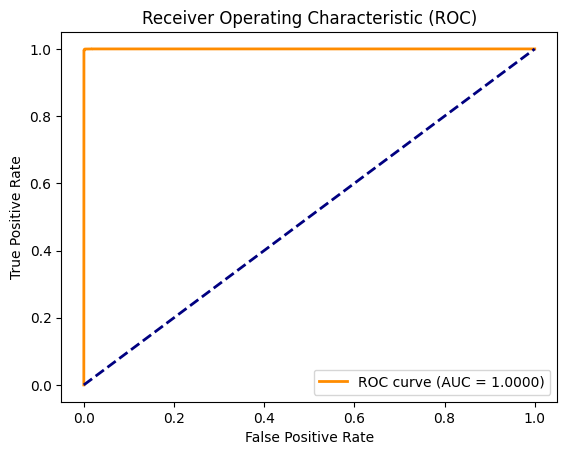

In [17]:

# Evaluate model on test set
def evaluate_model(model, test_loader, model_path):
    model = model.to('cuda:0')
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]  # probability of class "morphed"
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


#  Compute evaluation metrics
def compute_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print("\n=== Model Evaluation Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['bonafide', 'morphed']))

    return acc, prec, rec, f1, auc

#  Visualize Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['bonafide', 'morphed'],
                yticklabels=['bonafide', 'morphed'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


#  ROC Curve Visualization
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()


# Run everything together
y_true, y_pred, y_prob = evaluate_model(model, test_loader, "efficientnet_b3_morphing.pth")
acc, prec, rec, f1, auc = compute_metrics(y_true, y_pred, y_prob)
plot_confusion_matrix(y_true, y_pred)
plot_roc_curve(y_true, y_prob)